In [17]:
import os
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
exp_dir = '../unsupervised/exp/within_v2/'
results = {'modality':[], 'emb_type':[], 'idx_src':[], 'idx_tgt':[], 'epoch':[], 'loss':[], 'acc':[]}

diff = {'text-nn':[], 'text-normal':[], 'image-nn':[], 'image-normal':[]}

for modality in ['text', 'image']:
    for emb_type in ['nn', 'normal']:
        for idx_src in range(0,4):
            for idx_tgt in range(0,4):
                if idx_src != idx_tgt:
                    log_dir = os.path.join(exp_dir, f'{emb_type}_{modality}_{idx_src}-{emb_type}_{modality}_{idx_tgt}')
                    with open(os.path.join(log_dir, 'eval_acc.log'), 'r') as r:
                        acc_list = []
                        for line in r.readlines():
                            acc = float(line.split('Accuracy: ')[1][:-2])
                            acc_list.append(acc)
                        diff[f'{modality}-{emb_type}'].append(np.mean(acc_list))

In [19]:
for key in diff.keys():
    print(key, len(diff[key]), np.mean(diff[key]), scipy.stats.sem(diff[key]))

text-nn 12 93.409375 0.20822621299086008
text-normal 12 88.91708333333334 0.30935873209958514
image-nn 12 75.02875 0.5061849004159362
image-normal 12 52.22416666666667 0.8216651684170989


In [11]:

print(scipy.stats.ttest_ind(diff['image-normal'], diff['image-nn']))
print(scipy.stats.ttest_ind(diff['text-normal'], diff['text-nn']))

Ttest_indResult(statistic=-23.630020376469385, pvalue=3.9747197136498865e-17)
Ttest_indResult(statistic=-12.046622501040575, pvalue=3.6901637946822515e-11)


In [12]:
results = {'modality':[], 'emb_type':[], 'idx_src':[], 'idx_tgt':[], 'epoch':[], 'loss':[], 'acc':[]}

for modality in ['text', 'image']:
    for emb_type in ['nn', 'normal']:
        for idx_src in range(0,4):
            for idx_tgt in range(0,4):
                if idx_src != idx_tgt:
                    log_dir = os.path.join(exp_dir, f'{emb_type}_{modality}_{idx_src}-{emb_type}_{modality}_{idx_tgt}')
                    with open(os.path.join(log_dir, 'logger.log'), 'r') as r:
                        prev = None
                        for line in r.readlines():
                            if 'epoch' in line:
                                epoch = float(line.split()[3].split(':')[1][:-1])           
                                loss = float(line.split()[5].split(':')[1])
                                acc = float(line.split()[-1])
                                
                                if prev != acc:
                                    results['modality'].append(modality)
                                    results['emb_type'].append(emb_type)
                                    results['idx_src'].append(idx_src)
                                    results['idx_tgt'].append(idx_tgt)
                                    results['epoch'].append(epoch)
                                    results['loss'].append(loss)
                                    results['acc'].append(acc)
                                    prev = acc

df = pd.DataFrame(results)

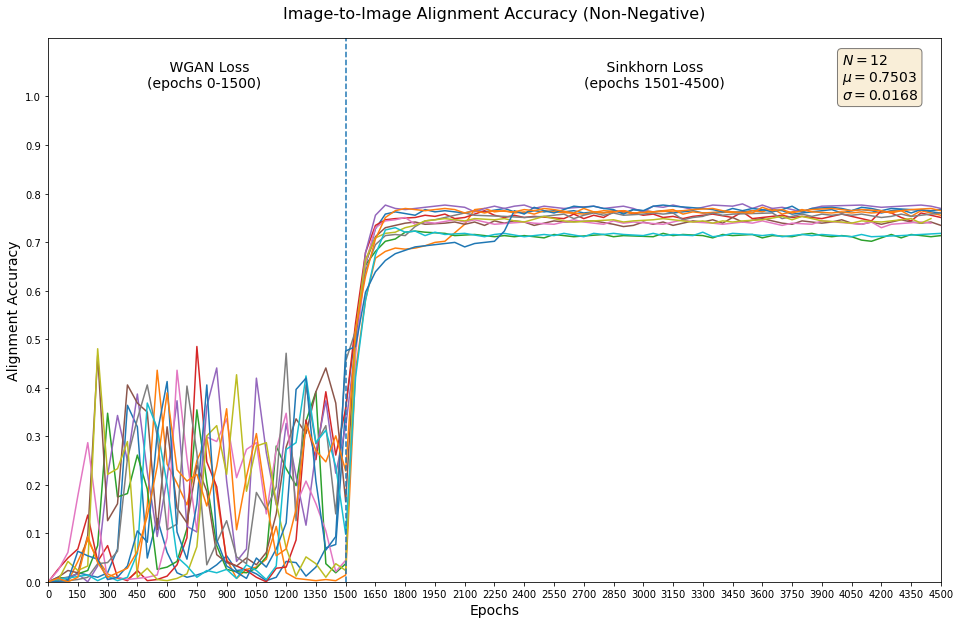

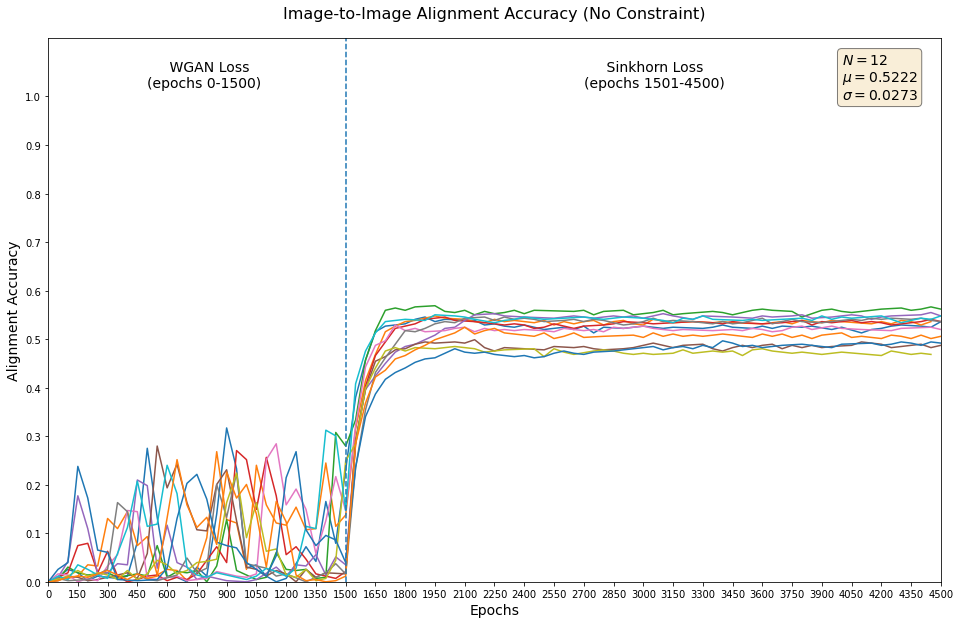

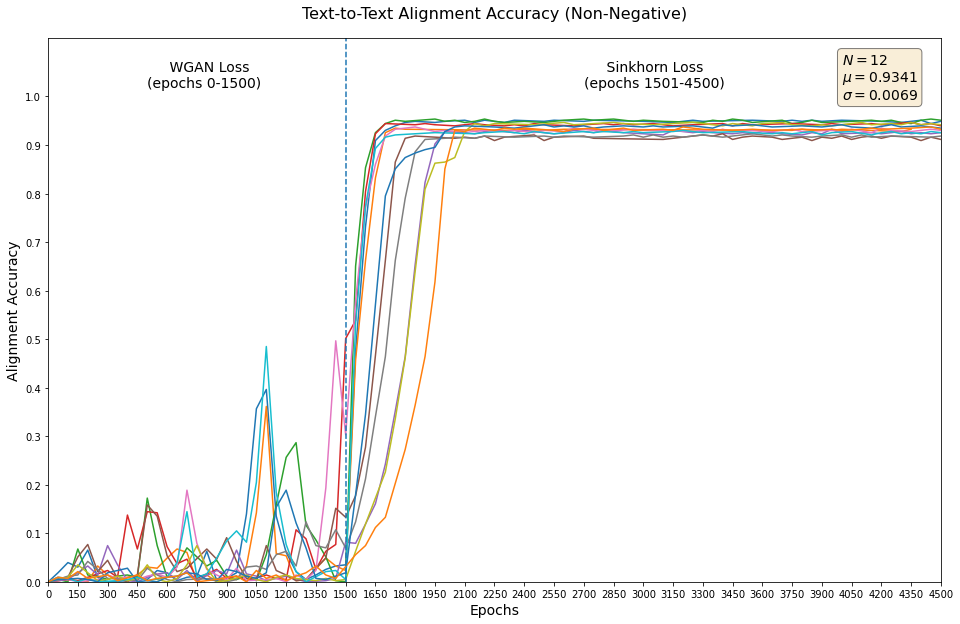

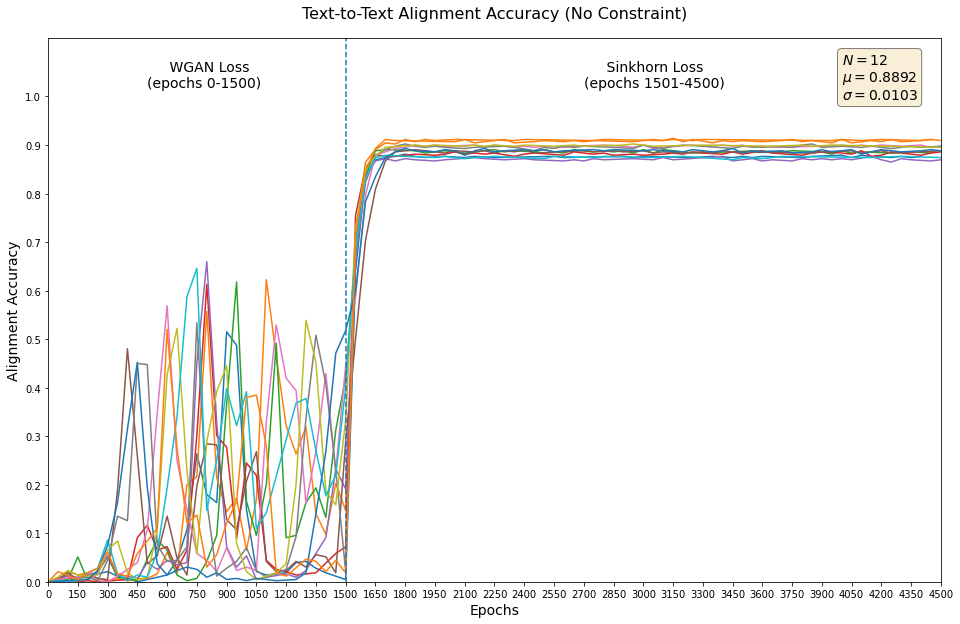

In [13]:
for modality in ['image','text']:
    for emb_type in ['nn', 'normal']:
        plt.figure(figsize=(16,10))
        for idx_src in range(0,4):
            for idx_tgt in range(0,4):
                if idx_src != idx_tgt:
                    df_plot = df.loc[(df['idx_src']==idx_src) & (df['idx_tgt']==idx_tgt) & (df['modality']==modality) & (df['emb_type']==emb_type)]
                    plt.plot(df_plot['epoch'], df_plot['acc'])


        title_prefix = 'Image-to-Image' if modality=='image' else 'Text-to-Text'
        title_suffix = '(Non-Negative)' if emb_type=='nn' else '(No Constraint)'
        title_main = 'Alignment Accuracy'

        plt.title(f'{title_prefix} {title_main} {title_suffix}', fontsize=16, pad=20)

        plt.text(500,1.02,'     WGAN Loss \n(epochs 0-1500)',fontsize=14)
        plt.text(2700,1.02,'     Sinkhorn Loss \n(epochs 1501-4500)',fontsize=14)
        plt.axvline(x=1500, ls='--')
        plt.xticks(np.arange(0, 4650, 150))
        plt.xlabel('Epochs', fontsize=14)
        plt.ylabel('Alignment Accuracy', fontsize=14)
        plt.xlim(0,4500)
        plt.ylim(0,1.12)
        plt.yticks(np.arange(0, 1.1, 0.1))
        
        # statistical info box
        N = 12
        mu = np.mean(diff[f'{modality}-{emb_type}'])/100
        sigma = np.std(diff[f'{modality}-{emb_type}'])/100       
        
        textstr = '\n'.join((
            r'$N=%.1d$' % (N, ),
            r'$\mu=%.4f$' % (mu, ),
            r'$\sigma=%.4f$' % (sigma, )))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        plt.text(4000, 1.09, textstr, fontsize=14,
                verticalalignment='top', bbox=props)
        plt.show()